In [1]:
cd ..\..

C:\Users\parax\Dropbox\Programming\Python\magnetisation_reconstruction\2D


In [2]:
import numpy as np
import json
import torch
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

from Magnetisation.Propagator import Propagator
from Magnetisation.Generator import generator_CNN
from Magnetisation.Train import Magnetisation_CNN_training
from Magnetisation.utils import LoadData

[[-7.53549450e-06  3.76237144e-06 -1.27441802e-05 ... -1.18102590e-04
  -1.89549238e-04 -3.48212020e-05]
 [-1.85335388e-07 -1.58980837e-05 -7.83011595e-06 ...  7.81515362e-06
   1.46931736e-05 -7.57854173e-06]
 [ 9.13390522e-06  1.12160046e-05 -6.04611319e-06 ...  2.62446948e-04
   1.30750446e-04  1.12563175e-06]
 ...
 [-1.35372647e-05 -9.29539423e-07  9.31861333e-06 ... -7.97709677e-07
  -7.85203110e-06 -1.20243194e-05]
 [ 5.83121325e-06  3.14234773e-06 -1.69652030e-05 ...  1.38910773e-05
  -4.26713368e-06 -9.06360634e-06]
 [ 1.07535631e-05 -1.01499826e-06  1.60494578e-05 ... -3.31850088e-06
  -7.80770041e-06 -1.01117701e-05]]


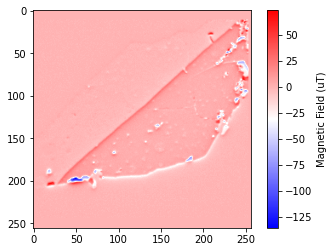

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Extract the data
f = open('data/Magnetisation out of plane/CrI3_Exp_B_20180525_001.json')
data = json.load(f)
MagneticField = np.asarray(data['ExperimentMagneticField']['BNV']['Data'])

# subtract the mean of the magnetic field
fft_signal = np.fft.fft2(MagneticField) 
fft_signal_clean = np.where(fft_signal.imag==0,0,fft_signal)
MagneticField = np.fft.ifft2(fft_signal_clean).real

MagneticField = MagneticField[:250,:250]

# Get the Fourier method propagation
Magnetization = np.array(data['ExperimentMagneticField']['MagnetisationPropagation']['Magnetisation']['Mag'])
Magnetization2 = Magnetization[:250,:250]
Magnetization3 = np.pad(Magnetization2,((12,11),(0,0)))
unit_conversion = 1e-18 / 9.27e-24

# Define the dictionary for the forward propagation
PropagationOptions = dict()
PropagationOptions['PixelSize'] = data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX']
PropagationOptions['ImageShape'] = 256
PropagationOptions['NV'] = dict()
PropagationOptions['NV']['FindTheta']=False
PropagationOptions['NV']['Theta'] = data['ExperimentMagneticField']['BNV']['Theta']
PropagationOptions['NV']['FindPhi']=False
PropagationOptions['NV']['Phi'] = data['ExperimentMagneticField']['BNV']['Phi'] 
PropagationOptions['NV']['Height'] = data['ExperimentMagneticField']['BNV']['Height'] 
PropagationOptions['Magnetisation'] = dict()
PropagationOptions['Magnetisation']['FindTheta']=False
PropagationOptions['Magnetisation']['Theta'] = 0
PropagationOptions['Magnetisation']['FindPhi']=False
PropagationOptions['Magnetisation']['Phi'] = 0
PropagationOptions['FFT'] = dict()
PropagationOptions["FFT"]["PaddingFactor"]= 4
PropagationOptions["FFT"]["performPadding"]= False
PropagationOptions["FFT"]["PaddingMode"] = 'constant'
PropagationOptions['FFT']['Extended'] = False
PropagationOptions['FFT']['Extention'] = 100
PropagationOptions['FFT']['Filter'] = dict()
PropagationOptions['FFT']['Filter']['useHanning'] = True 
PropagationOptions['FFT']['Filter']['useHighCutoff'] = False
PropagationOptions['FFT']['Filter']['useLowCutoff'] = False
PropagationOptions['FFT']['Filter']['LambdaHighCutoff'] = 100e-9
PropagationOptions['FFT']['Filter']['LambdaLowCutoff'] = 7e-06

PROP = Propagator(PropagationOptions, MagneticField,PropagationOptions['ImageShape'])

plt.imshow(PROP.MagneticFieldExtended, cmap="bwr")
plt.colorbar(label="Magnetic Field (uT)")

In [15]:
# Make the neural network
Generator = generator_CNN(Size=1, ImageSize=PROP.options['ImageShape']).to(device)

In [16]:
# Set the machine learning paramaters for keyword unpacking
ML_options = dict()
ML_options['mlp']=False
ML_options['LossFunction'] = 'L1'
ML_options['Epochs'] = 100
ML_options['Magnetization'] = None 
ML_options['PositiveMagnetisationOnly'] = False
ML_options['PrintLossValue'] = False
ML_options['IntegerOnly'] = False

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\parax\Dropbox\Programming\Python\magnetisation_reconstruction\2D\Magnetisation\Propagator.py:356: RuntimeWarning: invalid value encountered in true_divide
  [-(kx ** 2) / k, -(kx * ky) / k, -1j * kx],
C:\Users\parax\Dropbox\Programming\Python\magnetisation_reconstruction\2D\Magnetisation\Propagator.py:357: RuntimeWarning: invalid value encountered in true_divide
  [-kx * ky / k, -(ky ** 2 / k), -1j * ky],
C:\Users\parax\anaconda3\envs\py_new\lib\site-packages\torch\autograd\__init__.py:154: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:244.)
  Variable._execution_engine.run_backward(
100%|██████████| 100/100 [00:21<00:00,  4.61it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists who

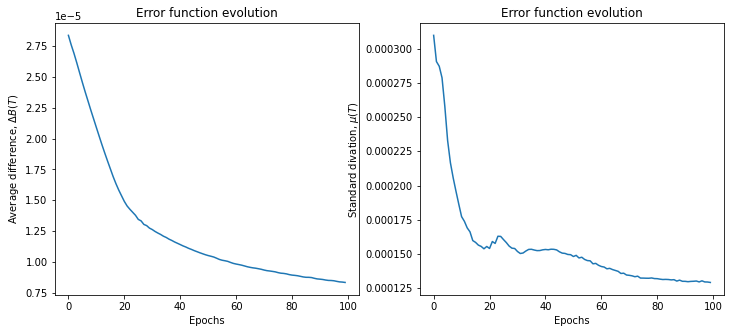

In [17]:
# Train the network
CNN_training = Magnetisation_CNN_training(device, Generator, PROP, ML_options)
bnv_cnn = CNN_training.train_cnn(**ML_options)

C:\Users\parax\Dropbox\Programming\Python\magnetisation_reconstruction\2D\Magnetisation\Train.py:274: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Results["Original B"] = np.rot90(self.PROP.MagneticFieldExtended[self.PROP.OriginalROI] * unit_conversion_M_to_B, k=1)
C:\Users\parax\Dropbox\Programming\Python\magnetisation_reconstruction\2D\Magnetisation\Train.py:275: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Results["Reconstructed B"] = np.rot90(ReconstructedBnv[self.PROP.OriginalROI] * unit_conversion_M_to_B , k=1)
C:\Users\parax\Drop

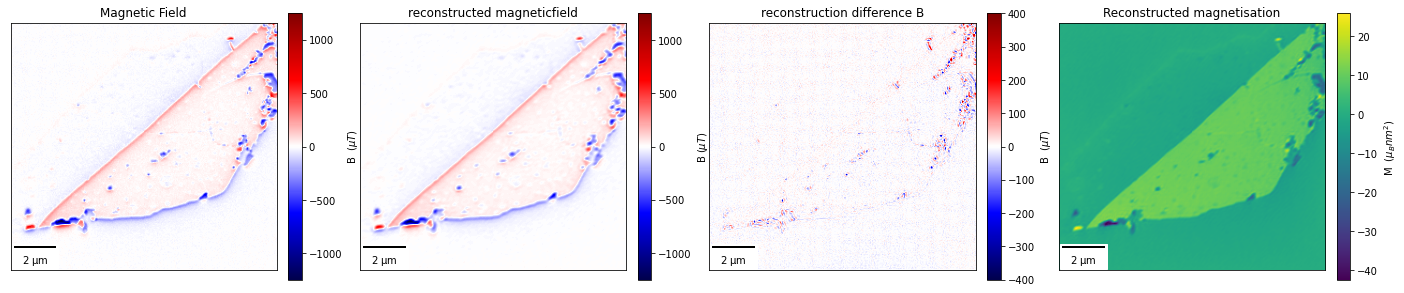

In [18]:
Results = CNN_training.extract_results(plotResults = True)